<a href="https://colab.research.google.com/github/LukeWeidenwalker/fastai-notebooks/blob/master/06_pascal_multicat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 18.9MB/s 
     |████████████████████████████████| 51kB 7.7MB/s 
     |████████████████████████████████| 194kB 56.3MB/s 
     |████████████████████████████████| 1.2MB 24.8MB/s 
     |████████████████████████████████| 61kB 9.3MB/s 
     |████████████████████████████████| 51kB 9.0MB/s 
     |████████████████████████████████| 12.8MB 52.9MB/s 
     |████████████████████████████████| 776.8MB 23kB/s 
ERROR: torchtext 0.9.0 has requirement torch==1.8.0, but you'll have torch 1.7.1 which is incompatible.
Mounted at /content/gdrive


In [2]:
from fastbook import *

In [3]:
path = untar_data(URLs.PASCAL_2007)

In [11]:
path.ls()


(#8) [Path('/root/.fastai/data/pascal_2007/segmentation'),Path('/root/.fastai/data/pascal_2007/valid.json'),Path('/root/.fastai/data/pascal_2007/train.csv'),Path('/root/.fastai/data/pascal_2007/test'),Path('/root/.fastai/data/pascal_2007/train.json'),Path('/root/.fastai/data/pascal_2007/test.json'),Path('/root/.fastai/data/pascal_2007/train'),Path('/root/.fastai/data/pascal_2007/test.csv')]

In [6]:
(path / "train") .ls()

(#5012) [Path('/root/.fastai/data/pascal_2007/train/006339.jpg'),Path('/root/.fastai/data/pascal_2007/train/009463.jpg'),Path('/root/.fastai/data/pascal_2007/train/000443.jpg'),Path('/root/.fastai/data/pascal_2007/train/004087.jpg'),Path('/root/.fastai/data/pascal_2007/train/003175.jpg'),Path('/root/.fastai/data/pascal_2007/train/009330.jpg'),Path('/root/.fastai/data/pascal_2007/train/005319.jpg'),Path('/root/.fastai/data/pascal_2007/train/005310.jpg'),Path('/root/.fastai/data/pascal_2007/train/009681.jpg'),Path('/root/.fastai/data/pascal_2007/train/001734.jpg')...]

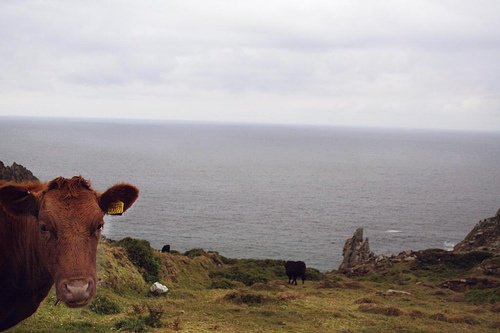

In [10]:
Image.open((path / "train/009463.jpg"))

In [12]:
df = pd.read_csv(path / "train.csv")

In [13]:
df.head(10)

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True
5,000017.jpg,person horse,False
6,000019.jpg,cat,True
7,000020.jpg,car,True
8,000021.jpg,dog person,True
9,000023.jpg,bicycle person,False


In [38]:
def get_x(r): return (path/"train") / r["fname"]
def get_y(r): return r["labels"].split(" ")
def splitter(df):
  train = df.index[~df["is_valid"]].tolist()
  valid = df.index[df["is_valid"]].tolist()
  return train,valid
  
pascal_block = DataBlock(blocks=(ImageBlock, MultiCategoryBlock), 
                         get_x=get_x, 
                         get_y=get_y, 
                         splitter=splitter,
                         item_tfms= RandomResizedCrop(128, min_scale=0.35))

In [39]:
pascal_block.datasets(df).train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [40]:
dls = pascal_block.dataloaders(df)

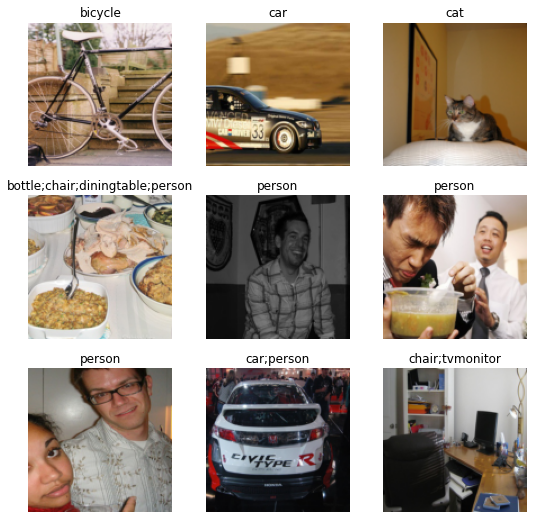

In [42]:
dls.show_batch()